# LAMMPS Tutorials 03. Uniaxial tension simulation!

### Author: Mark Tschopp, mark.a.tschopp.civ at mail.mil

Please contact me if you have a problem with this tutorial, so I can modify in Github.  I have added FAQs, and will update my versions of LAMMPS in the future to keep the scripts current.

The latest version of this [Jupyter Notebook](http://ipython.org/notebook.html) tutorial is available at https://github.com/mrkllntschpp/lammps-tutorials.

The original tutorials are given here: https://icme.hpc.msstate.edu/mediawiki/index.php/LAMMPS_tutorials.  A number of these tutorials are out of date and have been ported over into the current iPython Jupyter Notebook tutorials on github.

***
## Abstract:
<a id="Sec1"></a>

This example script shows how to run an atomistic simulation of uniaxial tensile loading of an aluminum single crystal oriented in the $<100>$ direction. This example uses a parallel molecular dynamics code, LAMMPS [1]. These scripts were initially used to study dislocation nucleation in single crystal aluminum and copper [2-4].  This example uses the Mishin et al. [5] aluminum potential.  The deformation movies were created using OVITO [6] and AtomEye [7] visualization tools.

<br>
<table width="700" border="0" cellpadding="5">
<tr>

<td width="200" align="center" valign="center">
<figure>
  <img src="https://icme.hpc.msstate.edu/mediawiki/images/d/d7/Al_SC_100_stress-strain.jpg" width="200" title="Stress-strain curve for uniaxial tensile loading of single crystal aluminum">
</figure>
</td>

<td width="200" align="center" valign="center">
<figure>
  <img src="https://icme.hpc.msstate.edu/mediawiki/images/d/d6/Al_SC_100_disl.jpg" width="200" title="FCC Dislocation nucleation">
</figure>
</td>

<td width="200" align="center" valign="center">
<figure>
  <img src="https://icme.hpc.msstate.edu/mediawiki/images/8/84/Al_SC_100_movie1.gif" width="200" title="FCC Deformation Movie" />
</figure>
</td>
</tr>
</table>

***
## Complete Tutorials One and Two 

If you have not done so already, complete the first two tutorials available [here](https://github.com/mrkllntschpp/lammps-tutorials). 

***
## Description of Simulation 
This LAMMPS [1] molecular dynamics simulation first generates a simulation cell with fcc atoms with $<100>$ orientations in the x, y, and z-directions. For this example, the simulation cell size is 10 lattice units in each direction, *i.e.*, 4000 total atoms. Larger simulation cell sizes should be used to converge the dislocation nucleation stress values and to not influence the dislocation nucleation mechanism. The potential used here is the Mishin *et al.* (1999) aluminum potential [5] used in Tutorials 1 and 2. The equilibration step allows the lattice to expand to a temperature of 300 K with a pressure of 0 bar at each simulation cell boundary. Then, the simulation cell is deformed in the x-direction at a strain rate of 10$^{10}$ s$^{-1}$, while the lateral boundaries are controlled using the NPT equations of motion to zero pressure. The stress and strain values are output to a separate file, which can be imported in a graphing application for plotting. The cfg dump files include the x, y, and z coordinates, the centrosymmetry values, the potential energies, and forces for each atom. This can be directly visualized using OVITO [6] and AtomEye [7] visualization tools. 

## Step 1: Create the LAMMPS input script 
This input script was run using the January 2020 version of LAMMPS. Changes in some commands may require revision of the input script. To run this script, store it in `in.tensile.txt` and then use `lmp_exe < in.tensile.txt` in a UNIX environment where `lmp_exe` refers to the LAMMPS executable. 

In [1]:
%%writefile in.tensile.txt
######################################
# LAMMPS INPUT SCRIPT
# Input file for uniaxial tensile loading of single crystal aluminum
# Mark Tschopp
# To execute, use the syntax "lmp_exe < in.tensile.txt" from command prompt

######################################
# VARIABLES
variable n_iter equal 20000

######################################
# INITIALIZATION
units metal
dimension 3
boundary p p p
atom_style atomic
variable latparam equal 4.05

######################################
# ATOM DEFINITION
lattice  fcc ${latparam} orient x 1 0 0 orient y 0 1 0 orient z 0 0 1
region whole block 0 10 0 10 0 10
create_box 1 whole
create_atoms 1 region whole

######################################
# DEFINE INTERATOMIC POTENTIAL
pair_style eam/alloy
pair_coeff * * Al99.eam.alloy Al

######################################
# DEFINE COMPUTES 
compute csym all centro/atom fcc
compute peratom all pe/atom 

######################################
# EQUILIBRATION
reset_timestep 0
timestep 0.001
velocity all create 300 12345 mom yes rot no
fix 1 all npt temp 300 300 1 iso 0 0 1 drag 1 

# Set thermo output
thermo 1000
thermo_style custom step lx ly lz press pxx pyy pzz pe temp

# Run for at least 10 picosecond (assuming 1 fs timestep)
run ${n_iter}
unfix 1

# Store final cell length for strain calculations
variable tmp equal "lx"
variable L0 equal ${tmp}
print "Initial Length, L0: ${L0}"

######################################
# DEFORMATION
reset_timestep 0

fix 1 all npt temp 300 300 1 y 0 0 1 z 0 0 1 drag 1
variable srate equal 1.0e10
variable srate1 equal "v_srate / 1.0e12"
fix 2 all deform 1 x erate ${srate1} units box remap x

# Output strain and stress info to file
# for units metal, pressure is in [bars] = 100 [kPa] = 1/10000 [GPa]
# p2, p3, p4 are in GPa
variable strain equal "(lx - v_L0)/v_L0"
variable p1 equal "v_strain"
variable p2 equal "-pxx/10000"
variable p3 equal "-pyy/10000"
variable p4 equal "-pzz/10000"
fix def1 all print 100 "${p1} ${p2} ${p3} ${p4}" file Al_tens_100.def1.txt screen no

# Use cfg for AtomEye
dump 1 all cfg 250 dump.tens_*.cfg mass type xs ys zs c_csym c_peratom fx fy fz
dump_modify 1 element Al

# Display thermo
thermo 1000
thermo_style custom step v_strain temp v_p2 v_p3 v_p4 ke pe press
run ${n_iter}

######################################
# SIMULATION DONE
print "All done"

Writing in.tensile.txt


OK. Easy enough.  You should have the file in your working directory if you are running this from Jupyter Notebook.

***
## Step 2: Run the Simulation

Now run the simulation as we have done before.  On my computer, the 24Jan2020 LAMMPS executable is stored in the `C:\Program Files\LAMMPS 64-bit 24Jan2020\bin\` folder and is named `lmp_serial.exe`.  The `log.lammps` file should look like the output below. Notice that the 20 ps (20,000 fs) equilibration step brought the temperature of the simulation cell up to 300 K. The corresponding deformation went up to a strain of 0.2. The thermo command was set for every 1000 timesteps, so any plots should be made from the data included in the datafile.

<br>
<div class="alert alert-danger">
Warning! This next simulation can take a little time to execute on a laptop or desktop (approximately 15 minutes or so).  Here is where you start to appreciate the ability to use multiple processors to break up the spatial domain of your simulations.  And this is just a small toy simulation... 
</div>

In [2]:
!lmp_serial < in.tensile.txt

LAMMPS (3 Mar 2020)
Lattice spacing in x,y,z = 4.05 4.05 4.05
Created orthogonal box = (0 0 0) to (40.5 40.5 40.5)
  1 by 1 by 1 MPI processor grid
Created 4000 atoms
  create_atoms CPU = 0.00161004 secs
Neighbor list info ...
  update every 1 steps, delay 10 steps, check yes
  max neighbors/atom: 2000, page size: 100000
  master list distance cutoff = 8.28721
  ghost atom cutoff = 8.28721
  binsize = 4.1436, bins = 10 10 10
  2 neighbor lists, perpetual/occasional/extra = 1 1 0
  (1) pair eam/alloy, perpetual
      attributes: half, newton on
      pair build: half/bin/atomonly/newton
      stencil: half/bin/3d/newton
      bin: standard
  (2) compute centro/atom, occasional
      attributes: full, newton on
      pair build: full/bin/atomonly
      stencil: full/bin/3d
      bin: standard
Setting up Verlet run ...
  Unit style    : metal
  Current step  : 0
  Time step     : 0.001
Per MPI rank memory allocation (min/avg/max) = 5.218 | 5.218 | 5.218 Mbytes
Step Lx Ly Lz Press Pxx Pyy 

For this simulation, additional commands were added to produce files beyond just the `log.lammps` file.  Notice that there are `dump.tens_XXXX.cfg` files (for visualization purposes) and a LAMMPS datafile `Al_tens_100.def1.txt` (short for Al/Aluminum, tens/tension, 100 for $<100>$ tensile direction.  These were the product of including the following lines to the input script:

`fix def1 all print 100 "${p1} ${p2} ${p3} ${p4}" file Al_tens_100.def1.txt screen no`

`dump 1 all cfg 250 dump.tens_*.cfg mass type xs ys zs c_csym c_peratom fx fy fz`

For instance, here is what they look like:

In [3]:
# If this works, that would be great: !cat Al_SC_100.def1.txt
f = open('Al_tens_100.def1.txt', 'r')
file_contents = f.read()
print (file_contents)
f.close()

# Fix print output for fix def1
0 0.00654420473794272 0.0112769288589897 0.0184296850082856
0.00100000000000011 0.0624081395603154 -0.00216322944588185 0.016083923764263
0.00200000000000005 0.109934617706495 -0.0187951125909629 -0.0313305168824378
0.00300000000000017 0.191247452338116 0.0172493814028649 0.0581080698425189
0.00400000000000011 0.22050485127792 -0.0184191869141977 -0.0110731015626537
0.00500000000000005 0.345382333235943 0.0322302242950974 0.0509586828399794
0.00600000000000016 0.355882606304076 -0.016925310265542 -0.0111445610901057
0.0070000000000001 0.454097922057753 0.0232455830291892 -0.0100774164959796
0.00800000000000004 0.493903743624308 -0.0223995265522064 0.00512363776593261
0.00900000000000015 0.561203616528841 0.00247790745768558 -0.0117870524133096
0.0100000000000001 0.633105907873837 0.0264310032096745 -0.025006804151489
0.011 0.705547292304506 -0.0297204077376555 -0.00676475661795768
0.0120000000000001 0.791308932430566 -0.00416046234301184 0.00018194270297

In [4]:
# If this works, that would be great: !cat dump.tensile_0.cfg
f = open('dump.tens_0.cfg', 'r')
file_contents = f.read()
print (file_contents)
f.close()

Number of particles = 4000
A = 1 Angstrom (basic length-scale)
H0(1,1) = 40.6501 A
H0(1,2) = 0 A 
H0(1,3) = 0 A 
H0(2,1) = 0 A 
H0(2,2) = 40.6501 A
H0(2,3) = 0 A 
H0(3,1) = 0 A 
H0(3,2) = 0 A 
H0(3,3) = 40.6501 A
.NO_VELOCITY.
entry_count = 8
auxiliary[0] = c_csym
auxiliary[1] = c_peratom
auxiliary[2] = fx
auxiliary[3] = fy
auxiliary[4] = fz
26.982000 
Al 
0.0512719 0.0463412 0.00471191 1.45669 -3.31471 0.0900081 0.473863 -0.544048 
26.982000 
Al 
0.00276101 0.0495094 0.0489156 0.51257 -3.32493 -0.282763 -0.229385 0.244644 
26.982000 
Al 
0.101208 0.0503832 0.051736 0.275394 -3.28837 -0.439154 -0.177426 -0.271738 
26.982000 
Al 
0.0482082 0.100248 0.0517863 0.218181 -3.34786 -0.01032 -0.0511796 -0.342577 
26.982000 
Al 
0.100135 0.0997173 0.00201337 0.283332 -3.32337 -0.408122 0.0954105 0.0340656 
26.982000 
Al 
0.0503231 0.048285 0.103087 0.639918 -3.30581 -0.172117 -0.0304571 -0.297089 
26.982000 
Al 
0.104218 0.000575278 0.101837 0.546107 -3.29553 -0.371481 -0.416292 -0.263148 
26.9

***
## Step 3: Post-Processing the Simulation 

So, now what?  Why don't we open the `Al_SC_100.def1.txt` file for a stress-strain curve, and then visualize the data from the cfg files to see what is happening with the atoms.

### Stress-Strain Plot Using MATLAB and Python

The stress-strain curve in Figure 1 can be generated using the following MATLAB script:

```OCTAVE
%% Analyze def1.txt files
% Plot the various responses

d = dir('*.def1.txt');
for i = 1:length(d)
    % Get data
    fname = d(i).name;
    A = importdata(fname);
    strain = A.data(:,1);
    stress = A.data(:,2:4);

    % Generate plot
    plot(strain,stress(:,1),'-or','LineWidth',2,'MarkerEdgeColor','r',...
                'MarkerFaceColor','r','MarkerSize',5),hold on
    plot(strain,stress(:,2),'-ob','LineWidth',2,'MarkerEdgeColor','b',...
                'MarkerFaceColor','b','MarkerSize',5),hold on
    plot(strain,stress(:,3),'-og','LineWidth',2,'MarkerEdgeColor','g',...
                'MarkerFaceColor','g','MarkerSize',5),hold on
    axis square
    ylim([0 10])
    set(gca,'LineWidth',2,'FontSize',24,'FontWeight','normal','FontName','Times')
    set(get(gca,'XLabel'),'String','Strain','FontSize',32,'FontWeight','bold','FontName','Times')
    set(get(gca,'YLabel'),'String','Stress (GPa)','FontSize',32,'FontWeight','bold','FontName','Times')
    set(gcf,'Position',[1 1 round(1000) round(1000)])

    % Export figure to tif file
    exportfig(gcf,strrep(fname,'.def1.txt','.tif'),'Format','tiff','Color','rgb','Resolution',300)
    close(1)
end
```

The exportfig command refers to a script on MATLAB Central File website. You will need to go to the website and download the script into the current directory for this to work.

<figure>
  <img src="https://icme.hpc.msstate.edu/mediawiki/images/d/d7/Al_SC_100_stress-strain.jpg" width="300" title="Stress-strain curve for uniaxial tensile loading of single crystal aluminum">
  <figcaption><strong>Figure 1.</strong> Stress-strain curve for uniaxial tensile loading of single crystal aluminum in the $<100>$ loading direction.
</figcaption>
</figure>

Or, you can make something in Python:

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import csv

results = []
with open('Al_tens_100.def1.txt',newline='') as file:
    reader = csv.reader(file, delimiter=' ')
    next(reader)  # Skip header row.
    for row in reader:
        row2 = [float(i) for i in row]
        results.append(row2)
        print(row2)


[0.0, 0.00654420473794272, 0.0112769288589897, 0.0184296850082856]
[0.00100000000000011, 0.0624081395603154, -0.00216322944588185, 0.016083923764263]
[0.00200000000000005, 0.109934617706495, -0.0187951125909629, -0.0313305168824378]
[0.00300000000000017, 0.191247452338116, 0.0172493814028649, 0.0581080698425189]
[0.00400000000000011, 0.22050485127792, -0.0184191869141977, -0.0110731015626537]
[0.00500000000000005, 0.345382333235943, 0.0322302242950974, 0.0509586828399794]
[0.00600000000000016, 0.355882606304076, -0.016925310265542, -0.0111445610901057]
[0.0070000000000001, 0.454097922057753, 0.0232455830291892, -0.0100774164959796]
[0.00800000000000004, 0.493903743624308, -0.0223995265522064, 0.00512363776593261]
[0.00900000000000015, 0.561203616528841, 0.00247790745768558, -0.0117870524133096]
[0.0100000000000001, 0.633105907873837, 0.0264310032096745, -0.025006804151489]
[0.011, 0.705547292304506, -0.0297204077376555, -0.00676475661795768]
[0.0120000000000001, 0.791308932430566, -0.0

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  if __name__ == '__main__':


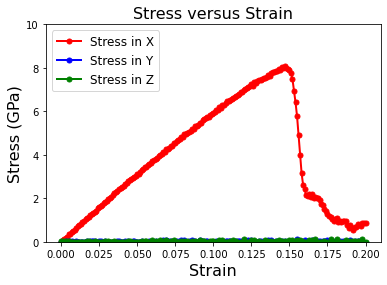

In [6]:
results2 = np.transpose(results)
plt.plot(results2[0],results2[1], '-or', label='Stress in X', lw=2, markersize = 5, mec = 'r', mfc = 'r')
plt.plot(results2[0],results2[2], '-ob', label='Stress in Y', lw=2, markersize = 5, mec = 'b', mfc = 'b')
plt.plot(results2[0],results2[3], '-og', label='Stress in Z', lw=2, markersize = 5, mec = 'g', mfc = 'g')
plt.xlabel('Strain',fontsize=16)
plt.ylabel('Stress (GPa)',fontsize=16)
plt.title('Stress versus Strain',fontsize=16)
plt.legend(fontsize=12)
plt.axis(aspect='equal')
plt.ylim(0,10)
plt.show()

***
## Step 4: Making the Deformation Movie 

OK, so there are a far greater number of different software visualization packages out there now than there were a decade ago.  I used to use AtomEye almost exclusively for visualization.  I then found ways to visualize things in MATLAB, where I could add a lot of different elements.  I would suggest downloading OVITO and trying it out, but there are a number of different packages.  The AtomEye and ImageJ thread of the tutorial is from a long time ago.  

### Visualization in Windows with OVITO

First download [OVITO](https://www.ovito.org/).
* Go to [OVITO](https://www.ovito.org/).
* Click on download, select operating system, and then create username to download.  Follow remaining instructions to get it on yoru computer.

OK.  Here goes:
* Open [OVITO](https://www.ovito.org/)
* Load file and select the `dump.tens_0.cfg` file.  OVITO will find the rest of the `*.cfg` files.
* Drag the slider bar at the bottom to `64/80` because that is about where the peak of the stress-strain curve above appears.
* Now, go to the `Add modification...` pull down list and select `Color coding`.  Now go to the bottom `Particle property` pulldown list and select `c_csym`.  Now click on adjust range to get a start and end value that is reasonable for viewing the dislocation.
* Click on the play button below to view the evolution of the deformation process.
* To create a movie, click on the `Render Active Viewport` tab up above.  In the `Rendering range` box, select `Complete animation`.  Click on `Save to file` and click on the `Choose...` button (name, "deformation-movie.png").  I like transparent background.  Then click on `Render Active Viewport` at the top for it to render the animation.
* Use ImageJ or whatever you like to pull all the images together into an animated gif or the like to create a movie file.

As a side note:
* If you want, you can `Add Modification...` and select all atoms with low centrosymmetry and delete these atoms from the view.  Unfortunately, the size of the periodic cell is not large enough to be able to view the dislocation nucleation and growth process all that well.  See below for a video with a slightly larger cell size.

For instance, change this to increase the simulation cell size from 10 by 10 by 10 (1000 by 4 atoms = 4000 atoms):
`region whole block 0 10 0 10 0 10`

or double the dimension to increase the number of atoms to 32,000 atoms:
`region whole block 0 20 0 20 0 20`

or increase the dimension to 50 by 50 by 50 to increase the number of atoms to 500,000 atoms:
`region whole block 0 50 0 50 0 50`

</br>
<div class="alert alert-warning">
  <strong>Warning!</strong> Don't expect that this will finish on your laptop very quickly.  Here is where you are going to need multiple processors and/or a supercomputer.
</div>


### Visualization in UNIX with AtomEye

First download [AtomEye](http://mt.seas.upenn.edu/Archive/Graphics/A/). 
* Go to [AtomEye](http://mt.seas.upenn.edu/Archive/Graphics/A/) website at http://mt.seas.upenn.edu/Archive/Graphics/A/. 
* Click on Download, this will take you to the raw binary files. 
* Download the A.i686 version by right-clicking on the link and "Save Target As..." to one of your directories. 
* Rename the downloaded file as A by typing "cp A.i686 A". A will be the executable. 
* Using UNIX, run "chmod A 755" on the file to change this to an executable. 
* To test, you need to save a CFG file as well, such as cnt8x3.cfg. Try running using "./A cnt8x3.cfg". 

Next download [ImageJ](http://rsbweb.nih.gov/ij/). 
* Go to [ImageJ](http://rsbweb.nih.gov/ij/) website at http://rsbweb.nih.gov/ij/. 
* Download the appropriate version for Windows, LINUX, or MAC. 

This assumes that you already have AtomEye and ImageJ downloaded and installed. 
* Visualize the dumpfile in AtomEye by typing the following command, "/A dump.tensile_0.cfg" (UNIX). 
* Use the AtomEye options to select how you want to visualize deformation. In this example, the centrosymmetry parameter was used to show only atoms in a non-centrosymmetric environment (see Fig. 2). 
    * Use Alt+0 to activate centrosymmetric (csym) view. 
    * Adjust threshold, or set of atoms to view, by using Shift+T. This will allow creation of a set for the current parameter (in this case, csym). Please note that you need to adjust both lower and higher thresholds unless the atoms from following images that exceeds maximum value for the first one will be not shown. You can make it 5 or 10. 
    * Make atoms with values outside of the threshold invisible by using Ctrl+A. 
* Press 'y' within AtomEye to produce an animation script. 
* The folder "Jpg" now contains snapshots of all dumpfiles. 
* Open ImageJ 
* Drag the folder Jpg into ImageJ 
    * Select "Convert to RGB" to keep the color from the AtomEye images. 
    * Choose "yes" to load a stack. 
* Adjust the size as needed (Image/Adjust/Size) 
* Adjust frame rate as desired (Image/Stacks/Tools/Animation Options) 
* Save as Animated Gif file 

<br>
<table width="700" border="0" cellpadding="5">
<tr>

<td width="300" align="center" valign="center">
<figure>
  <img src="https://icme.hpc.msstate.edu/mediawiki/images/d/d6/Al_SC_100_disl.jpg" width="250" alt="Face-centered Cubic Lattice Structure" title="FCC Lattice Structure">
    <figcaption><strong>Figure 2.</strong> Image of nucleated dislocation near peak stress.</figcaption>
</figure>
</td>

<td width="300" align="center" valign="center">
<figure>
  <img src="https://icme.hpc.msstate.edu/mediawiki/images/8/84/Al_SC_100_movie1.gif" width="250" alt="Face-centered Cubic Lattice Structure" title="FCC Lattice Structure" />
  <figcaption><strong>Figure 3.</strong> Tensile Loading of an Aluminum Single Crystal. Movie showing deformation of single crystal aluminum loaded in the $<100>$ direction at a strain rate of 10$^{10}$ s$^{-1}$ and a temperature of 300 K. Only atoms in non-centrosymmetric environment are shown.
  </figcaption>
</figure>
</td>
</tr>
</table>
 

***
## FAQs 

<br>
<div class="alert alert-danger">
    <strong>Question 1</strong>: I ran this tutorial of an atomistic simulation of uniaxial tensile loading of an aluminum single crystal oriented in the $<100>$ direction. However, I want to use the LJ potential instead of the EAM potential. When I run the input script with the Lennard Jones potential, I get much different results. The stress is nearly 3 times the stress from the EAM potential. I don't know where something is wrong. 
</div>

Interatomic potentials play a commanding role in the properties of molecular dynamics simulations. The most simple potential is the Lennard Jones potential. The embedded atom method potential is a little more sophisticated and I would encourage you to look up the original papers by Mike Baskes (1983, 1984) to examine how this common potential formulation was created. While there are an increasing number of potential formulations out there now and an increasing number of potentials, the embedded atom method has been widely used over the years and still is. However, this brings up the point that different potentials may give vastly different properties because each potential may have been formulated for a particular problem. It is up to the user to decide whether the potential seems to give plausible results for their application or whether the initial fitting contains properties that are important for their application.

<br>
<div class="alert alert-danger">
    <strong>Question 2</strong>: I want to deform this in a different direction, like the $<110>$ direction.  How do I do this?
</div>

As shown in [Tutorial 1](LAMMPS-Tutorials-01.ipynb), you will need to modify the `lattice  fcc ${latparam} orient x 1 0 0 orient y 0 1 0 orient z 0 0 1` command.  Try this: `lattice  fcc ${latparam} orient x 1 1 0 orient y -1 1 0 orient z 0 0 1`.  It should work!

As a side note, I used similar techniques with dislocation nucleation for a number of different crystal orientations and systems, studying the peak nucleation stresses in single crystal Cu/Al [2,3,4,8] and even Mg [9].  Just with much larger simulation cell sizes and lower strain rates!  And I had to program many of the deformation and post-processing routines that are readily available in LAMMPS today.  :(

<br>
<div class="alert alert-danger">
    <strong>Question 3</strong>: After the initial equilibration, the simulation box is deformed
in the x-direction at a strain rate of 10^10 1/s.  That is implemented in the LAMMPS script in the following lines: <br><br>
units 		metal<br>
...<br>
timestep 0.001  #in picosecond <br>
... <br>
variable srate equal 1.0e10<br>
variable srate1 equal "v_srate / 1.0e12"<br>
fix 2 all deform 1 x erate ${srate1} units box remap x<br><br>
How do you calculate the factor of 1.0e12? Isn't the timestep `dt` involved here in some way?
</div>

Great question.  First, the [units metal](https://lammps.sandia.gov/doc/units.html) command sets the default unit of time to `time = picoseconds` (i.e., 1e-12 s).  Depending on your potential, your type of simulation, etc., the timestep can assume a range of values, but for the purposes of this simulation, we define a timestep of 1 fs (1e-15 s), so this LAMMPS script simply uses `timestep 0.001` (the picosecond is assumed).

Now, we want a strain rate of 1.0e10 1/s.  So, _srate_ is a variable of the strain rate that is wanted.  But, we need it in the default unit of picoseconds, so we do a simple unit conversion to obtain _srate1_, i.e., seconds to picoseconds means multiplying by 1e-12 ps/s, which is also 1/1e12 ps/s.  So, then _srate1_ is fed into the `fix deform` command. 

Isn't the timestep involved? It definitely is! It is just not needed as an input to the [https://lammps.sandia.gov/doc/fix_deform.html](fix deform) command. Per the command above, the `erate` is defined. To calculate the change in length `L` as a function of time `L(t)`, LAMMPS calculates this using `L(t) = L0 (1 + erate*dt)` where _dt_ is the timestep.  This command assumes that the timestep is going to be defined via the separate timestep command.   


***
## Links

* [Click here to open Tutorial 1](LAMMPS-Tutorials-01.ipynb)
* [Click here to open Tutorial 2](LAMMPS-Tutorials-02.ipynb)
* [Click here to open the next tutorial](LAMMPS-Tutorials-04.ipynb)

***
## References 

1. S. Plimpton, "Fast Parallel Algorithms for Short-Range Molecular Dynamics," J. Comp. Phys., 117, 1-19 (1995). 
1. Spearot, D.E., Tschopp, M.A., Jacob, K.I., McDowell, D.L., "Tensile strength of <100> and <110> tilt bicrystal copper interfaces," Acta Materialia 55 (2007) p. 705-714 (http://dx.doi.org/10.1016/j.actamat.2006.08.060). 
1. Tschopp, M.A., Spearot, D.E., McDowell, D.L., "Atomistic simulations of homogeneous dislocation nucleation in single crystal copper," Modelling and Simulation in Materials Science and Engineering 15 (2007) 693-709 (http://dx.doi.org/10.1088/0965-0393/15/7/001). 
1. Tschopp, M.A., McDowell, D.L., "Influence of single crystal orientation on homogeneous dislocation nucleation under uniaxial loading," Journal of Mechanics and Physics of Solids 56 (2008) 1806-1830. (http://dx.doi.org/10.1016/j.jmps.2007.11.012). 
1. Y. Mishin, D. Farkas, M.J. Mehl, and D.A. Papaconstantopoulos, "Interatomic potentials for monoatomic metals from experimental data and ab initio calculations," Phys. Rev. B 59, 3393 (1999). 
1. A. Stukowski, "Visualization and analysis of atomistic simulation data with OVITO – the Open Visualization Tool," Modelling Simul. Mater. Sci. Eng. 18 (2010) 015012.
1. J. Li, "AtomEye: an efficient atomistic configuration viewer," Modelling Simul. Mater. Sci. Eng. 11 (2003) 173. 
1.  MA Tschopp, DL McDowell, "[Tension-compression asymmetry in homogeneous dislocation nucleation in single crystal copper](https://doi.org/10.1063/1.2715137)," Applied physics letters 90 (12), 121916
1. CD Barrett, H El Kadiri, MA Tschopp, "[Breakdown of the Schmid law in homogeneous and heterogeneous nucleation events of slip and twinning in magnesium](https://doi.org/10.1016/j.jmps.2012.06.015)," Journal of the Mechanics and Physics of Solids 60 (12), 2084-2099.